# Dataset Generation Tools

In this notebook, we generate signals used for our wireless adversarial machine learning tasks.

In [17]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

sns.set() # Use seaborn themes.

In [2]:
roots = dict(
    dataset = Path('./dataset/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

## Complex Time Series

TensorFlow does not currently accept complex numbers in loss functions. The reason is because complex numbers are not ordered, but real numbers are (see [StackOverflow](https://stackoverflow.com/a/58876622)).

One solution is to convert the I/Q data into magnitude and phase components, which can then be used as input features to the model.

In [3]:
def n2t(
    n: int|tuple[int,int]|np.ndarray[int],
    fs: float,
    ) -> np.ndarray[float]:
    """Convert discrete sample vector to time.

    Args:
        n (int | tuple[int,int] | np.ndarray[int]): Number of samples to simulate, or 2-tuple of discrete sample ranges, or vector of discrete samples.
        fs (float): Sample rate (Hz).

    Returns:
        np.ndarray[float]: Vector of time values (units of seconds).
    """
    if isinstance(n, int): # Discrete sample vector starting from zero.
        n = np.r_[0:n]
    elif isinstance(n, (list,tuple)): # 2-tuple of discrete range indices.
        assert len(n) == 2,'vector slice must be a 2-tuple'
        n = np.r_[n[0]:n[1]]
    return n.astype(float)/fs # Time vector.

def t2n(
    t: float|tuple[float,float]|np.ndarray[float],
    fs: float,
    ) -> np.ndarray[int]:
    """Convert time sample vector to discrete.

    Args:
        t (float | tuple[float,float] | np.ndarray[float]): Length of time vector (starting from zero), or 2-tuple of time ranges, or vector of time samples.
        fs (float): Sample rate (Hz).

    Returns:
        np.ndarray[int]: Vector of discrete sample values.
    """
    if isinstance(t, float): # Discrete sample vector starting from zero.
        t = np.r_[0.:t]
    elif isinstance(t, (list,tuple)): # 2-tuple of discrete range indices.
        assert len(t) == 2,'vector slice must be a 2-tuple'
        t = np.r_[t[0]:t[1]]
    return (t*fs).astype(int)

In [4]:
def wave(
    fc: float|np.ndarray[float] = 0.,
    t: np.ndarray[float] = 0.,
    amp: float|np.ndarray[float] = 1.,
    phi: float|np.ndarray[float] = 0.,
    ) -> np.ndarray[np.complex64]:
    """Sinusoid waveform generator from time vector.

    Args:
        fc (float|np.ndarray[float], optional): Carrier frequency (Hz). Defaults to zero.
        t (np.ndarray[float], optional): Vector of time values (seconds). Defaults to zero.
        amp (float|np.ndarray[float], optional): Signal amplitude, or vector of amplitudes. Defaults to one.
        phi (float|np.ndarray[float], optional): Signal phase, or vector of phases. Defaults to zero.

    Returns:
        np.ndarray[np.complex64]: Complex sinusoid values.
    """
    if phi is None: # Catch phase being set null.
        phi = 0.
    if fc is None: # Catch carrier frequency being set to null.
        fc = 0.
    if t is None: # Catch time vector being set to null.
        t = 0.
    if amp is None: # Catch amplitude being set to null.
        amp = 1.
    k = 2.*np.pi*fc*t + phi # Content of Euler's formula.
    x = amp*np.exp(1.j*k) # Complex sinusoid.
    return x

## Modulation Schemes

Here we define several modulation schemes that are used to generate our dataset. The PySDR "Digital Modulation" guides have a wonderful tutorial on this ([source](https://pysdr.org/content/digital_modulation.html)).

In [5]:
def repeat(
    x: np.ndarray[int|float],
    baud: int,
    fs: float,
    ) -> np.ndarray[int|float]:
    """Generates a list where each element in the input is repeated to satisfy the given baud rate and sample rate.

    Args:
        x (np.ndarray[int | float]): Input element vector.
        baud (int): Symbol rate (bits/second).
        fs (float): Sample rate (Hz).

    Returns:
        np.ndarray[int|float]: Vector of repeated input elements.
    """
    n_x = len(x) # Number of input elements to repeat.
    n_samples_per_x = int(fs/baud) # Number of elements per symbol.
    n_samples = n_x*n_samples_per_x # Total number of samples for the number of elements we have.
    rep = np.repeat(x, n_samples_per_x) # Repeat each element the necessary number of times.
    return rep

In [6]:
def ask(
    scheme: np.ndarray[float],
    bits: np.ndarray[int],
    baud: int,
    fs: float,
    fc: float = None,
    return_symbol: bool = False,
    ) -> np.ndarray[float]:
    """Amplitude shift keying (ASK) modulation.

    Args:
        scheme (np.ndarray[float]): Bit-to-symbol lookup array.
        bits (np.ndarray[int]): Array of bits to modulate.
        fs (float): Sample rate (Hz).
        fc (float, optional): Carrier frequency (Hz). Defaults to None.
        return_symbol (bool, optional): Flag to return modulated amplitudes. Defaults to False.

    Returns:
        np.ndarray[float]: Vector of modulated signal (`return_symbol=False`), or amplitudes (`return_symbol=True`)
    """

    # Lookup symbol for each bit.
    sym = scheme[bits]

    # Generate data series for symbols.
    amp = repeat(
        x=sym,
        baud=baud,
        fs=fs,
    )
    if return_symbol:
        return amp

    # Generate time vector.
    if fc is None:
        t = None
    else:
        n_samples = len(amp)
        t = n2t(n=n_samples, fs=fs)

    # Generate signal.
    x = wave(fc=fc, t=t, amp=amp, phi=None)
    return x

In [7]:
def psk(
    scheme: np.ndarray[float],
    bits: np.ndarray[int], # Bits to encode.
    baud: int, # Symbol rate (bits/second).
    fs: float,
    fc: float = None,
    return_symbol: bool = False,
    ) -> np.ndarray[float]:
    """Phase shift keying (PSK) modulation.

    Args:
        scheme (np.ndarray[float]): Bit-to-symbol lookup array.
        bits (np.ndarray[int]): Array of bits to modulate.
        fs (float): Sample rate (Hz).
        fc (float, optional): Carrier frequency (Hz). Defaults to None.
        return_amplitude (bool, optional): Flag to return modulated phases. Defaults to False.

    Returns:
        np.ndarray[float]: Vector of modulated signal (`return_symbol=False`), or phases (`return_symbol=True`).
    """
    # Lookup symbol for each bit.
    sym = scheme[bits]

    # Lookup phases for each bit in the sequence.
    phi = repeat(
        x=sym,
        baud=baud,
        fs=fs,
    )
    if return_symbol:
        return phi

    # Generate time vector.
    if fc is None:
        t = None
    else:
        n_samples = len(phi)
        t = n2t(n=n_samples, fs=fs)

    # Generate signal.
    x = wave(fc=fc, t=t, amp=None, phi=phi)
    return x

def bpsk(*args, **kwargs):

    ###
    # BPSK Modulation
    #
    # Symbol    Phase
    # 0         0
    # 1         pi
    ###
    scheme = np.array([0, np.pi])
    return psk(scheme, *args, **kwargs)

def qpsk(*args, **kwargs):

    ###
    # QPSK Modulation
    #
    # Symbol    Phase
    # 00         pi/4
    # 01         7pi/4
    # 10         3pi/4
    # 11         5pi/4
    ###
    scheme = np.array([np.pi/4, 7*np.pi/4, 3*np.pi/4, 5*np.pi/4])
    return psk(scheme, *args, **kwargs)

In [8]:
def qam(
    scheme: np.ndarray[float],
    bits: np.ndarray[int], # Bits to encode.
    baud: int, # Symbol rate (bits/second).
    fs: float,
    fc: float = None,
    return_symbol: bool = False,
    ):

    # Lookup symbol for each bit.
    sym = scheme[bits]

    # Lookup phases for each bit in the sequence.
    sym_rep = repeat(
        x=sym,
        baud=baud,
        fs=fs,
    )
    if return_symbol:
        return sym_rep

    # Generate time vector.
    if fc is None:
        t = None
    else:
        n_samples = len(sym_rep)
        t = n2t(n=n_samples, fs=fs)

    # Decompose complex symbols into amplitude and phase components so the waveform can be properly constructed.
    amp = np.abs(sym_rep)
    phi = np.angle(sym_rep, deg=False) # Radians

    # Generate signal.
    x = wave(fc=fc, t=t, amp=amp, phi=phi)
    return x

# Generalized M-QAM.
# Inspired by https://stackoverflow.com/a/41697024
def qam_m(m: int, *args, **kwargs):
    b = np.log2(m) # Get number of bits from M-QAM scheme.
    b_I = int(np.floor(b/2)) # Number of bits for in-phase.
    n_sym_I = 2**b_I # Number of symbols for in-phase.
    b_Q = int(np.ceil(b/2)) # Number of bits for quadrature-phase.
    n_sym_Q = 2**b_Q # Number of symbols for quadrature-phase.
    sym_I = np.arange(-(n_sym_I-1)/2, (n_sym_I-1)/2+1) # In-phase symbols.
    sym_Q = np.arange(-(n_sym_Q-1)/2, (n_sym_Q-1)/2+1) # Quadrature-phase symbols.
    sym_IQ = np.tile(sym_I, (n_sym_Q,1)) + 1j*np.tile(sym_Q, (n_sym_I,1)).T # Symbol grid.
    scheme = sym_IQ.T.flatten() # Transpose and flatten to orient from bottom-left to top-left orientation.
    return qam(scheme, *args, **kwargs)


# def qam_16(*args, **kwargs):
#     scheme = np.array([
#         -3 - 3j,
#         -3 -1j,
#         -3 + 3j,
#         -3 + 1j,
#         -1 - 3j,
#         -1 - 1j,
#         -1 + 3j,
#         -1 + 1j,
#         3 - 3j,
#         3 - 1j,
#         3 + 3j,
#         3 + 1j,
#         1 - 3j,
#         1 - 1j,
#         1 + 3j,
#         1 + 1j,
#     ])
#     return qam(scheme, *args, **kwargs)

## Helper functions to save data

In [26]:
def save_data(fname: str, data: dict[str, np.ndarray], **params):
    # Save compressed numpy NPZ format.
    np.savez_compressed(f"{fname}.npz", **data)

    # Save parameters as JSON.
    with open(f"{fname}.json", 'w') as f:
        params = dict(**params)
        json.dump(params, f)

## Plotting

In [37]:
def plot(
    n: np.ndarray,
    s: np.ndarray,
    x: np.ndarray,
    fs: float,
    baud: int,
    ):

    plt.figure()

    fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,12))
    pkey = 'A'
    axd[pkey].plot(n, s, marker='o', markevery=int(fs/baud))
    axd[pkey].set_title('Data')

    pkey = 'B'
    axd[pkey].plot(n, np.real(x), label='real')
    axd[pkey].plot(n, np.imag(x), label='imag')
    axd[pkey].set_title('Signal')
    axd[pkey].legend()

    pkey = 'C'
    axd[pkey].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
    axd[pkey].set_title('Constellation')
    axd[pkey].grid(True)

    return fig

## Examples

### Simple Waveform

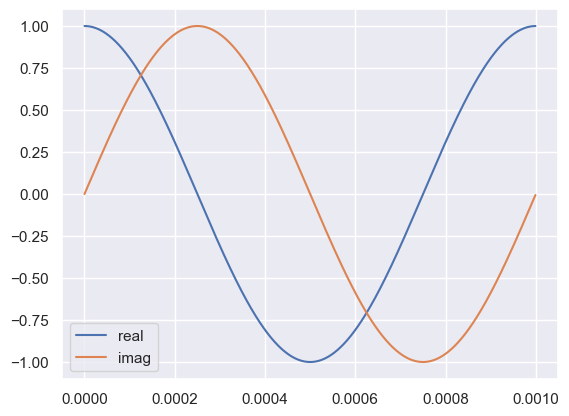

In [9]:
fc = 1e3
fs = 10e5
n_samples = 1000
t = n2t(n=n_samples, fs=fs)
phi = None
x = wave(fc=fc, t=t, phi=phi)

plt.plot(t, np.real(x), label='real')
plt.plot(t, np.imag(x), label='imag')
plt.legend()

### BPSK

<Figure size 640x480 with 0 Axes>

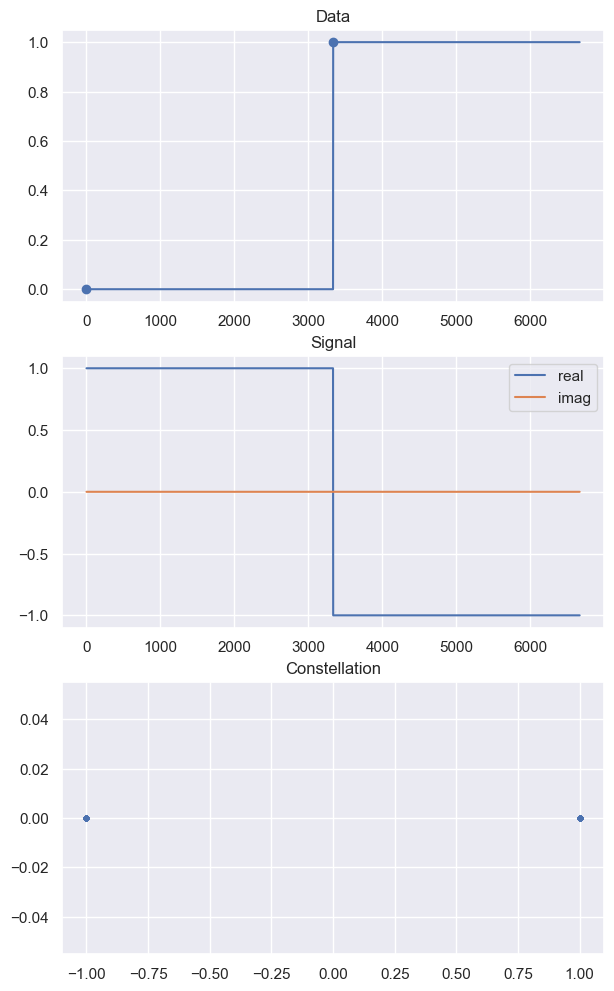

In [38]:
fc = None # 1e3
fs = 10e5
bits = np.arange(0, 2)
baud = 300
x = bpsk(bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"bpsk", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)

### QPSK

<Figure size 640x480 with 0 Axes>

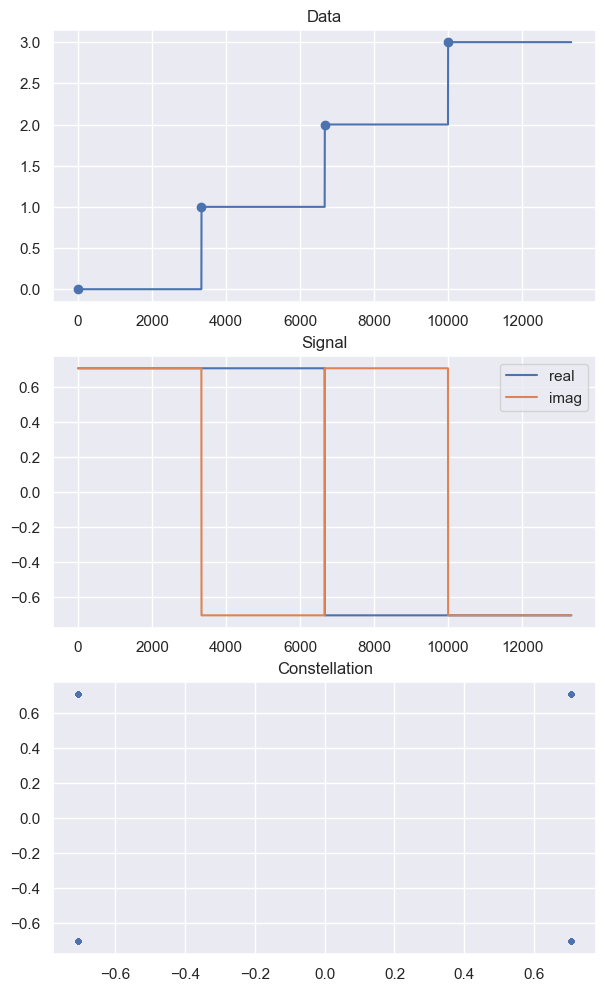

In [39]:
fc = None # 1e3
fs = 10e5
bits = np.arange(0, 4)
baud = 300
x = qpsk(bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"qpsk", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)

## 2-ASK

<Figure size 640x480 with 0 Axes>

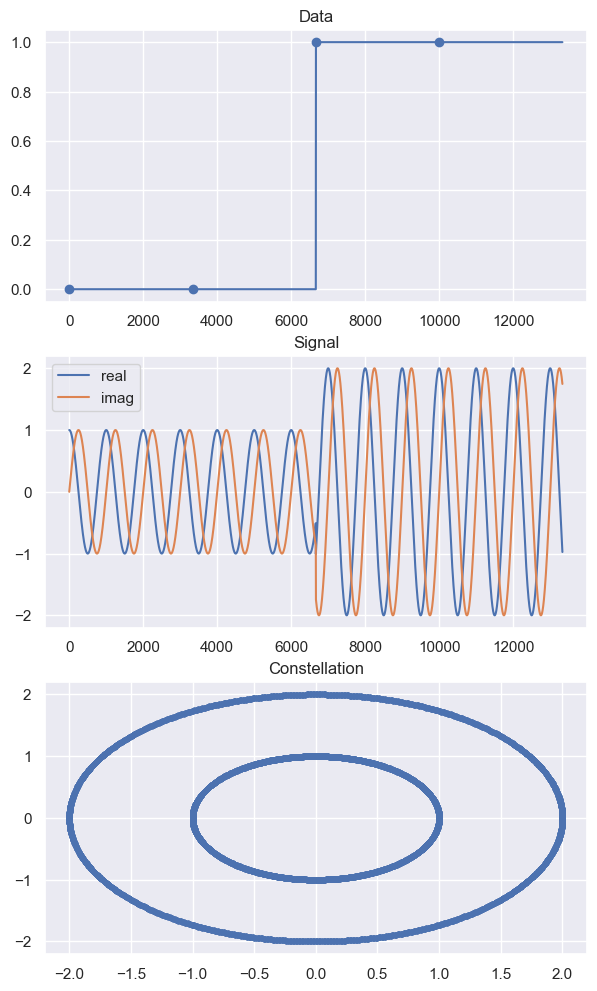

In [40]:
fc = 1e3
fs = 10e5
bits = np.random.randint(0, 2, size=4) # [0, 1, 0, 1]
baud = 300
scheme = np.array([1., 2.])
x = ask(scheme=scheme, bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"2-ask", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)

### 16-QAM

<Figure size 640x480 with 0 Axes>

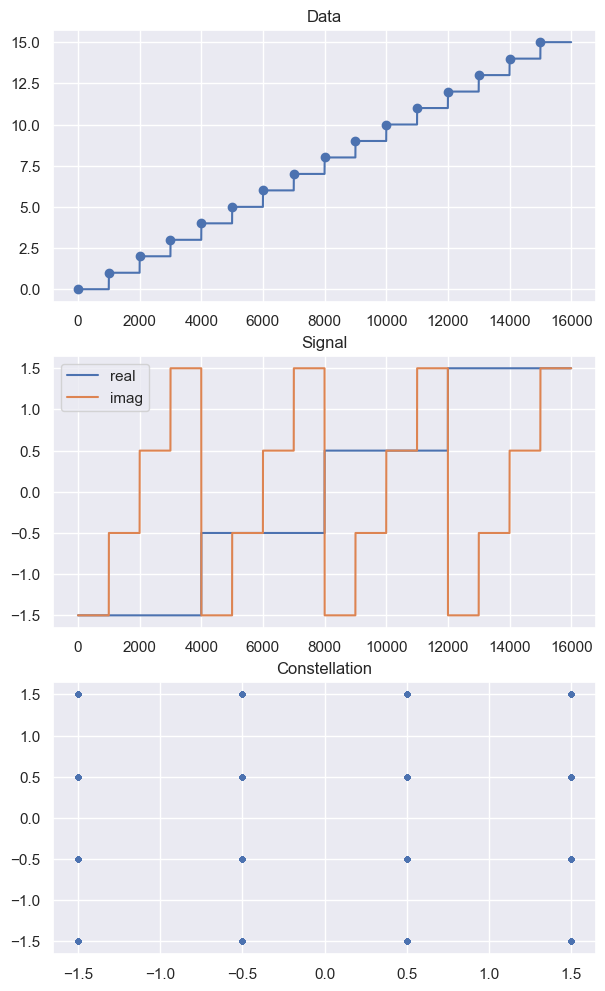

In [41]:
fc = None # 1e3
fs = 10e5
baud = 1e3
m = 16 # M-QAM
bits = np.arange(0, m)
x = qam_m(m=m, bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"16-qam", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)

### 64-QAM

<Figure size 640x480 with 0 Axes>

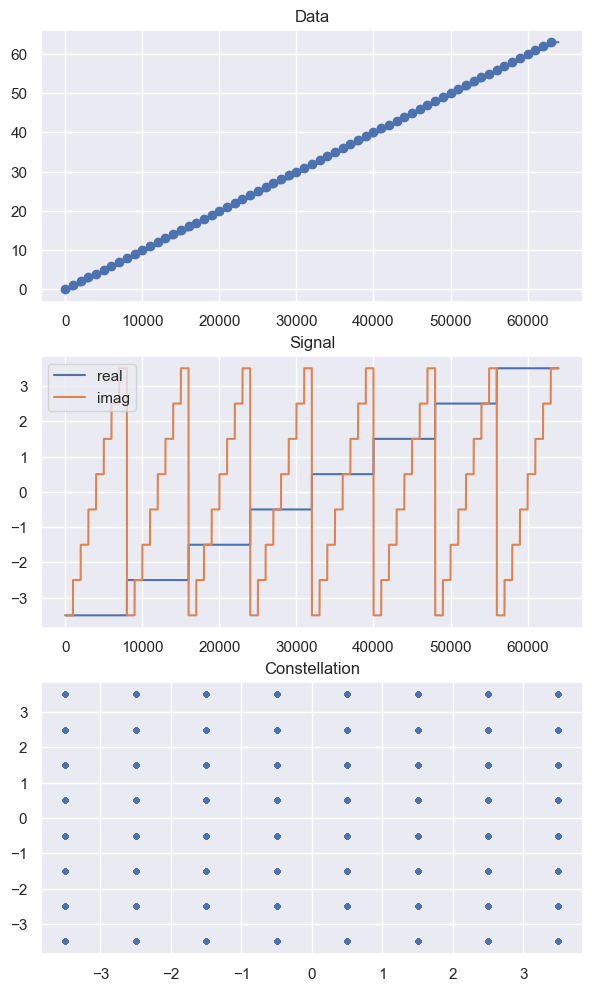

In [42]:
fc = None # 1e3
fs = 10e5
baud = 1e3
m = 64 # M-QAM
bits = np.arange(0, m)
x = qam_m(m=m, bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"64-qam", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)

### Very long 64-QAM sequence

<Figure size 640x480 with 0 Axes>

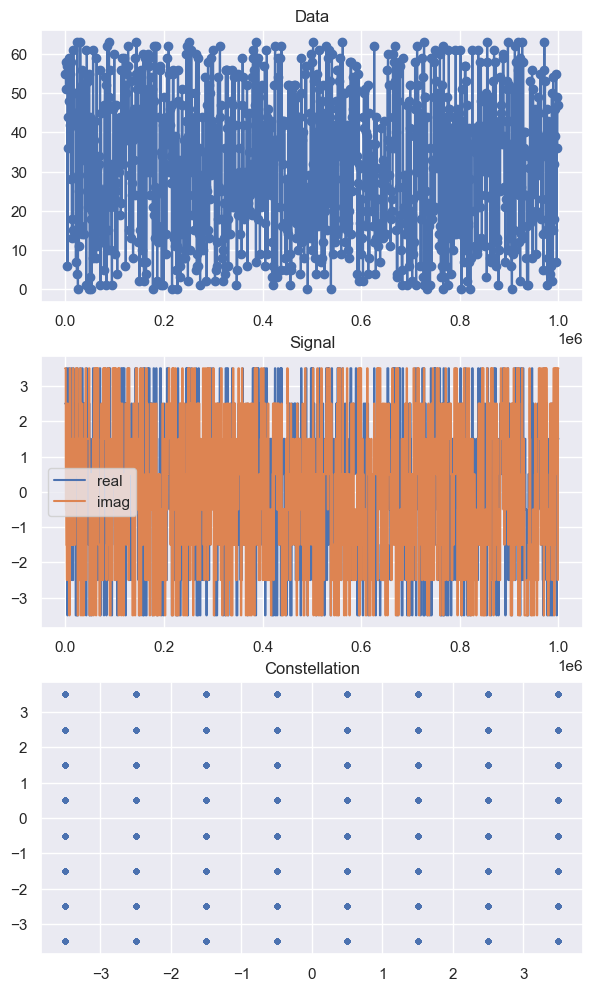

In [43]:
fc = None # 1e3
fs = 10e5
baud = 1e3
m = 64 # M-QAM
bits = np.random.randint(0, m, size=1000)
x = qam_m(m=m, bits=bits, baud=baud, fs=fs, fc=fc)
n = np.r_[0:len(x)]
t = n2t(n=n, fs=fs)
symbols = repeat(bits, baud=baud, fs=fs)

# Save data in compressed numpy format.
data = dict(
    n=n,
    t=t,
    x=x,
    s=symbols,
)
params = dict(
    features=list(data.keys()),
    bits=bits.tolist(),
    fc=fc,
    fs=fs,
    baud=baud,
    size=x.size,
)
save_data(fname=roots['dataset']/f"64-qam-long", data=data, **params)

# Plot
fig = plot(
    n=n,
    s=symbols,
    x=x,
    fs=fs,
    baud=baud,
)